# Task - Text2Image

Image is generated from a given text prompt (or with a negative prompt).

If encounter OOM errors, on can use
 - variant="fp16" while loading model
 - pipe.enable_model_cpu_offload() to offload the model to CPU


In [1]:
import os, torch
from diffusers import AutoPipelineForText2Image

os.environ["NCCL_P2P_DISABLE"] = "1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2024-08-01 10:32:12.033234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 10:32:12.033302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 10:32:12.101131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 10:32:12.220333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 10:32:14.911282: W tensorflow/compiler/tf2

cuda


## I. Text to image

In [3]:

prompt = "a picture train station with several trains, a lot of people, poles, and buildings, \
        happy tone, daylight, sunny with blue sky, cute, cartoonish, and beautiful"
negative_prompt = "bad quality, low quality"

generator = torch.Generator(device=device).manual_seed(42)

### stable diffusion 1 & 2

/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Keyword arguments {'torch_device': 'cuda'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/Qingyi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


  0%|          | 0/50 [00:00<?, ?it/s]

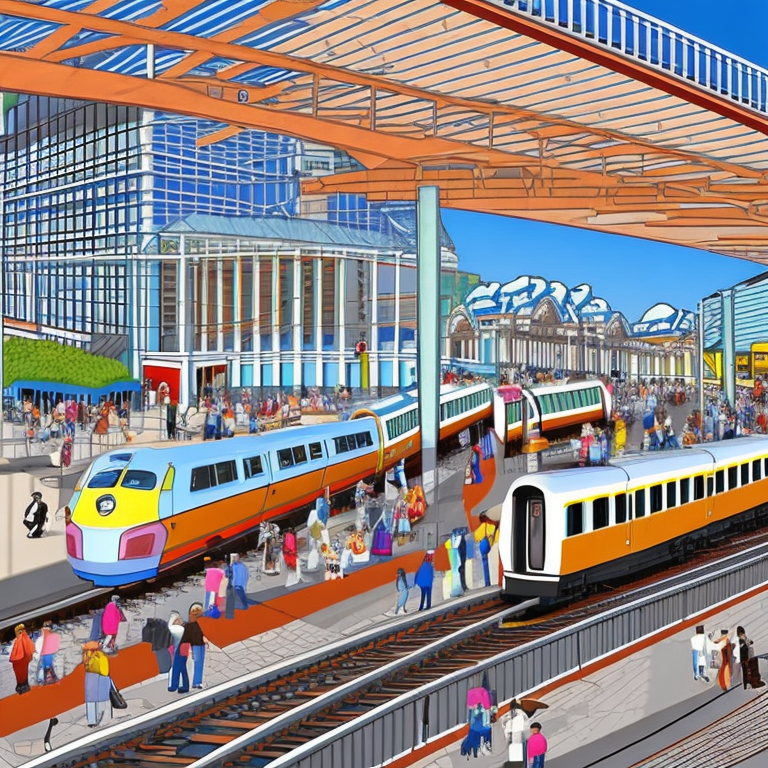

In [4]:
# stable diffusion v1.5
# "runwayml/stable-diffusion-v1-5"
# 
# "stabilityai/stable-diffusion-2-1"

pipe_text2img = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-2-1", use_safetensors=True)

pipe_text2img = pipe_text2img.to("cuda")

image = pipe_text2img(prompt, negative_prompt=negative_prompt, generator=generator, torch_device=device)[0][0]
image

### stable diffusion XL (SDXL)

/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Keyword arguments {'torch_device': 'cuda'} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/Qingyi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


  0%|          | 0/50 [00:00<?, ?it/s]

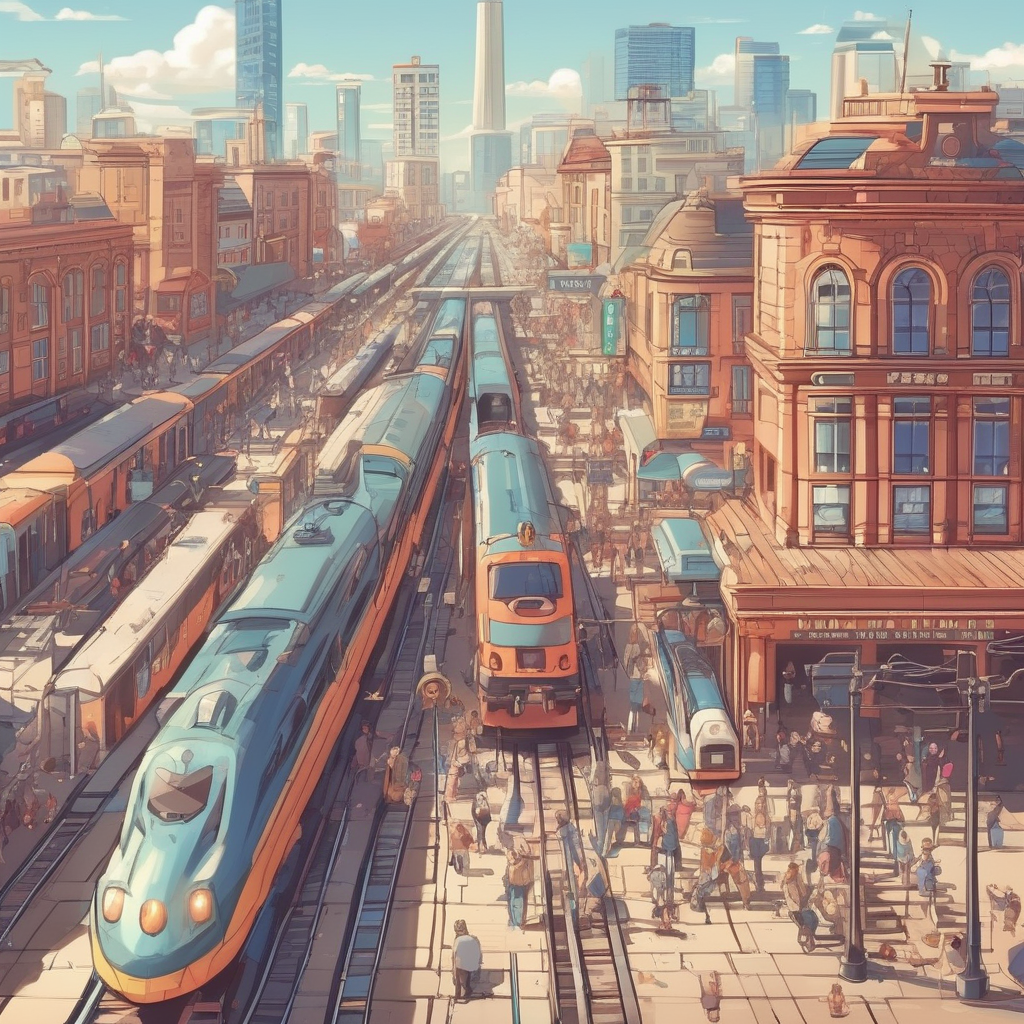

In [3]:
# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0

pipe_xl = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                    use_safetensors=True, 
                                                    torch_device=device,
                                                    torch_dtype=torch.float16,
                                                    variant="fp16"
                                                    )
pipe_xl = pipe_xl.to("cuda")

image = pipe_xl(prompt, generator=generator)[0][0]

image

### SDXL with refiner

/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

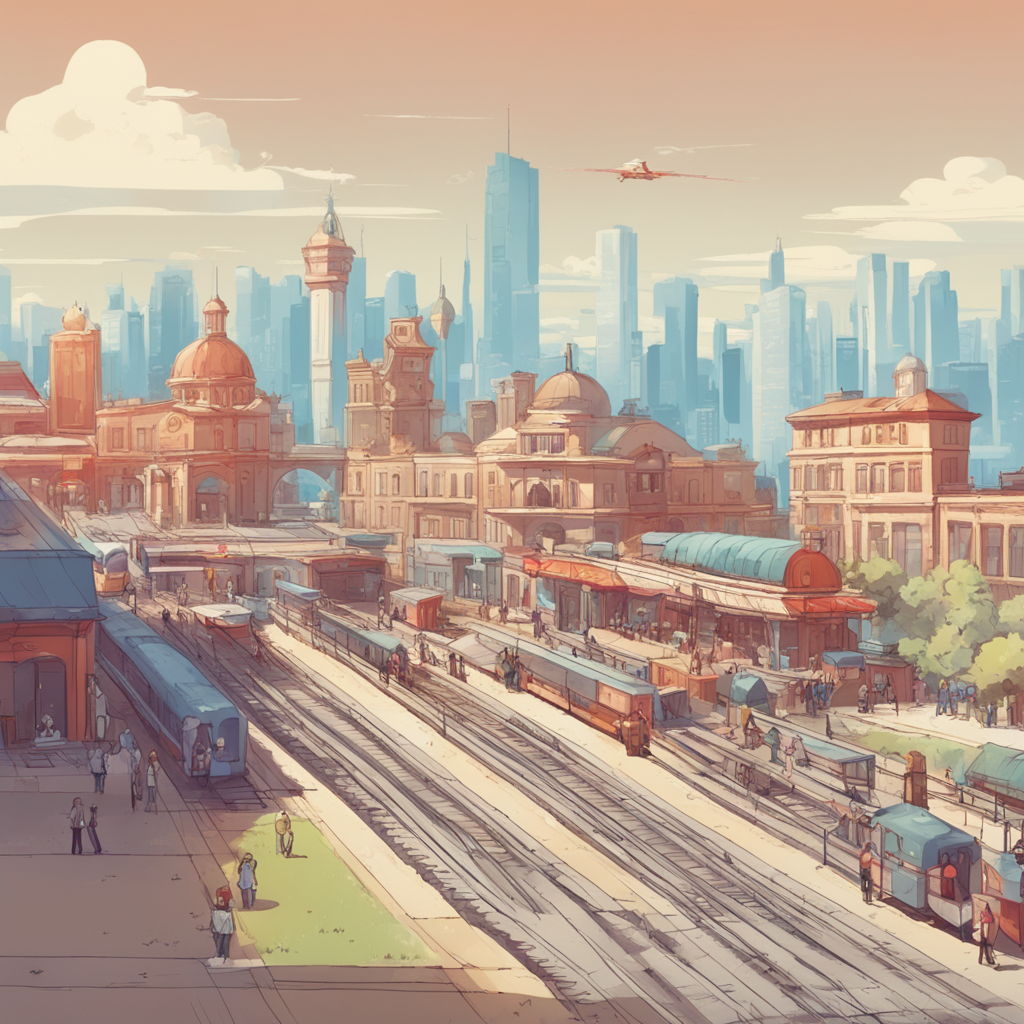

In [4]:
from diffusers import DiffusionPipeline
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=pipe_xl.text_encoder_2,
    vae=pipe_xl.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

image = pipe_xl(
    prompt=prompt,
    num_inference_steps=40,
    denoising_end=0.8,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=40,
    denoising_start=0.8,
    image=image,
).images[0]
image

### Kandinsky

/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

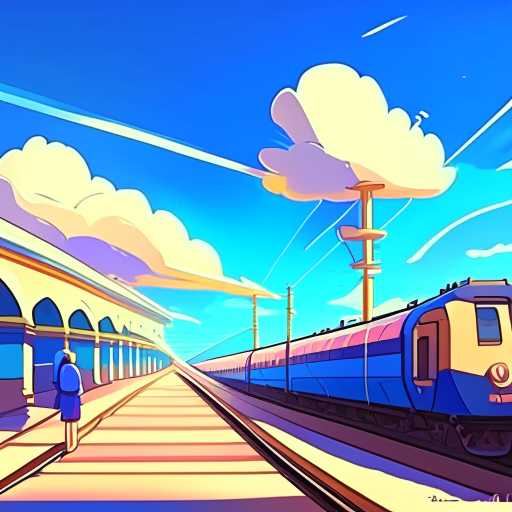

In [4]:
# https://huggingface.co/docs/diffusers/using-diffusers/kandinsky

pipe_kandinsky = AutoPipelineForText2Image.from_pretrained("kandinsky-community/kandinsky-2-1", use_safetensors=True, torch_dtype=torch.float16)

pipe_kandinsky = pipe_kandinsky.to("cuda")

image = pipe_kandinsky(prompt, 
                       negative_prompt=negative_prompt,
                       prior_guidance_scale=1.0, 
                       guidance_scale=4.0, 
                       generator=generator)[0][0]

image


### Stable Diffusion XL Turbo

/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/Qingyi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


  0%|          | 0/1 [00:00<?, ?it/s]

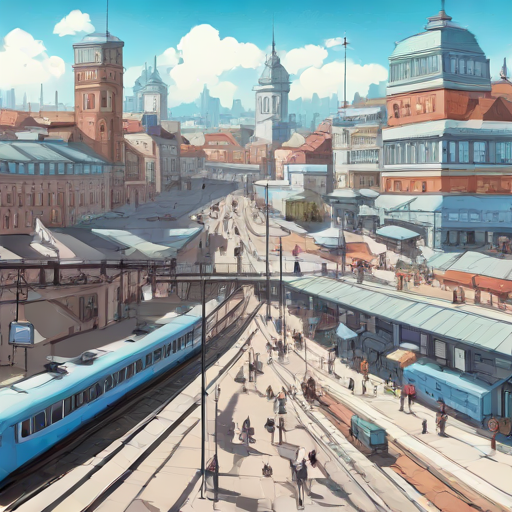

In [4]:
# pipe_turbo = pipe_turbo

pipe_turbo = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16", use_safetensors=True)

pipe_turbo = pipe_turbo.to("cuda")

image = pipe_turbo(prompt, generator=generator, guidance_scale=0.0, num_inference_steps=1).images[0]

image